In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import pickle
import cv2
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, BatchNormalization, Conv2D, Dense, Dropout, Flatten, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

In [1]:
train_dataset_path = '/home/user/Documents/Task/dataset/train/'
val_dataset_path = '/home/user/Documents/Task/dataset/val/'

In [3]:
IMG_WIDTH = 150
IMG_HEIGHT = 150
BATCH_SIZE = 32

In [4]:
train_data_generate = ImageDataGenerator(rescale=1.0/255,
                                  zoom_range=0.2,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  fill_mode='nearest')
train_generator = train_data_generate.flow_from_directory(train_dataset_path,
                                                   target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                   batch_size=BATCH_SIZE,
                                                   class_mode='categorical',
                                                   shuffle=True)

Found 4411 images belonging to 2 classes.


In [5]:
val_data_generate = ImageDataGenerator(rescale=1.0/255)
val_generator = val_data_generate.flow_from_directory(val_dataset_path,
                                                             target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                             batch_size=BATCH_SIZE,
                                                             class_mode='categorical',
                                                             shuffle=True)

Found 70 images belonging to 2 classes.


In [6]:
labels = {value: key for key, value in train_generator.class_indices.items()}

print("Label Mappings for classes present in the training and validation datasets\n")
for key, value in labels.items():
    print(f"{key} : {value}")

Label Mappings for classes present in the training and validation datasets

0 : metal
1 : plastic


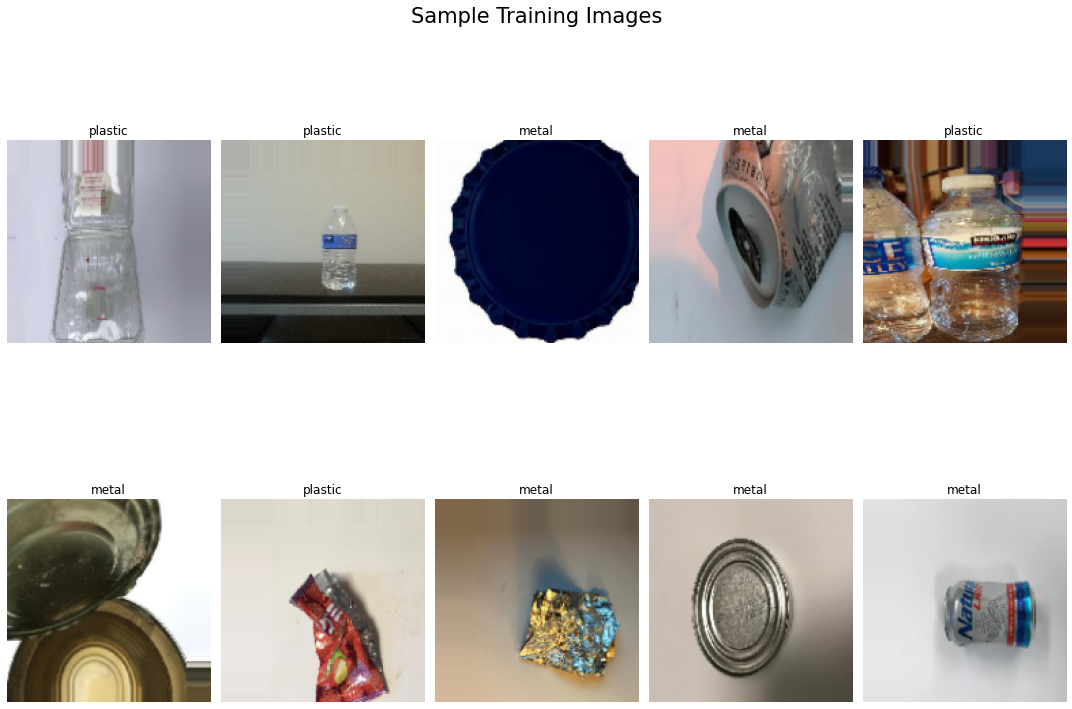

In [7]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(15, 12))
idx = 0

for i in range(2):
    for j in range(5):
        label = labels[np.argmax(train_generator[0][1][idx])]
        ax[i, j].set_title(f"{label}")
        ax[i, j].imshow(train_generator[0][0][idx][:, :, :])
        ax[i, j].axis("off")
        idx += 1

plt.tight_layout()
plt.suptitle("Sample Training Images", fontsize=21)
plt.show()

In [8]:
def create_model():
    model = Sequential([
        Conv2D(filters=128, kernel_size=(5, 5), padding='valid', input_shape=(IMG_WIDTH, IMG_HEIGHT, 3)),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),
        
        Conv2D(filters=64, kernel_size=(3, 3), padding='valid', kernel_regularizer=l2(0.00005)),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),
        
        Conv2D(filters=32, kernel_size=(3, 3), padding='valid', kernel_regularizer=l2(0.00005)),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),
        
        Flatten(),
        
        Dense(units=256, activation='relu'),
        Dropout(0.5),
        Dense(units=2, activation='softmax')
    ])
    
    return model

In [9]:
cnn_model = create_model()

In [10]:
print(cnn_model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 146, 146, 128)     9728      
                                                                 
 activation (Activation)     (None, 146, 146, 128)     0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 73, 73, 128)       0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 73, 73, 128)       512       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 71, 71, 64)        73792     
                                                                 
 activation_1 (Activation)   (None, 71, 71, 64)        0

In [11]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=np.sqrt(0.1), patience=5)

In [12]:
optimizer = Adam(learning_rate=0.001)

In [13]:
cnn_model.compile(optimizer=optimizer, loss=CategoricalCrossentropy(), metrics=['accuracy'])

In [ ]:
history = cnn_model.fit(train_generator,
                        epochs=50,
                        validation_data=val_generator,
                        verbose=2,
                        callbacks=[reduce_lr])

Epoch 1/50
138/138 - 529s - loss: 1.6824 - accuracy: 0.6971 - val_loss: 2.4000 - val_accuracy: 0.5143 - lr: 0.0010 - 529s/epoch - 4s/step
Epoch 2/50
138/138 - 531s - loss: 0.8348 - accuracy: 0.7645 - val_loss: 1.8474 - val_accuracy: 0.5000 - lr: 0.0010 - 531s/epoch - 4s/step
Epoch 3/50
138/138 - 518s - loss: 0.5336 - accuracy: 0.7966 - val_loss: 0.9271 - val_accuracy: 0.6000 - lr: 0.0010 - 518s/epoch - 4s/step
Epoch 4/50
138/138 - 473s - loss: 0.4590 - accuracy: 0.8155 - val_loss: 0.6208 - val_accuracy: 0.7571 - lr: 0.0010 - 473s/epoch - 3s/step
Epoch 5/50
138/138 - 524s - loss: 0.4067 - accuracy: 0.8404 - val_loss: 0.5957 - val_accuracy: 0.7571 - lr: 0.0010 - 524s/epoch - 4s/step
Epoch 6/50
138/138 - 510s - loss: 0.3832 - accuracy: 0.8415 - val_loss: 0.5430 - val_accuracy: 0.7286 - lr: 0.0010 - 510s/epoch - 4s/step
Epoch 7/50
138/138 - 500s - loss: 0.3648 - accuracy: 0.8533 - val_loss: 0.5700 - val_accuracy: 0.8286 - lr: 0.0010 - 500s/epoch - 4s/step
Epoch 8/50
138/138 - 526s - loss: 

In [ ]:
pickle.dump(model, open('model.pkl', 'wb'))

In [ ]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

train_loss = history.history['loss']
val_loss = history.history['val_loss']

learning_rate = history.history['lr']

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(12, 10))

ax[0].set_title('Training Accuracy vs. Epochs')
ax[0].plot(train_accuracy, 'o-', label='Train Accuracy')
ax[0].plot(val_accuracy, 'o-', label='Validation Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend(loc='best')

ax[1].set_title('Training/Validation Loss vs. Epochs')
ax[1].plot(train_loss, 'o-', label='Train Loss')
ax[1].plot(val_loss, 'o-', label='Validation Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend(loc='best')

ax[2].set_title('Learning Rate vs. Epochs')
ax[2].plot(learning_rate, 'o-', label='Learning Rate')
ax[2].set_xlabel('Epochs')
ax[2].set_ylabel('Loss')
ax[2].legend(loc='best')

plt.tight_layout()
plt.show()

In [ ]:
test_dataset = '/home/user/Documents/Task/dataset/test/'

In [ ]:
test_data_generate = ImageDataGenerator(rescale=1.0/255)
test_generator = test_data_generate.flow_from_directory(test_dataset,
                                                 shuffle=False,
                                                 batch_size=BATCH_SIZE,
                                                 target_size = (IMG_WIDTH, IMG_HEIGHT),
                                                 class_mode='categorical')

In [ ]:
predictions = cnn_model.predict(test_generator)

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(12, 10))
idx = 0

for i in range(2):
    for j in range(5):
        predicted_label = labels[np.argmax(predictions[idx])]
        ax[i, j].set_title(f"{predicted_label}")
        ax[i, j].imshow(test_generator[0][0][idx])
        ax[i, j].axis("off")
        idx += 1

plt.tight_layout()
plt.suptitle("Test Dataset Predictions", fontsize=20)
plt.show()

In [ ]:
test_loss, test_accuracy = cnn_model.evaluate(test_generator, batch_size=BATCH_SIZE)

In [ ]:
print(f"Test Loss:     {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

In [ ]:
y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes

In [ ]:
cf_mtx = confusion_matrix(y_true, y_pred)

group_counts = ["{0:0.0f}".format(value) for value in cf_mtx.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_mtx.flatten()/np.sum(cf_mtx)]
box_labels = [f"{v1}\n({v2})" for v1, v2 in zip(group_counts, group_percentages)]
box_labels = np.asarray(box_labels).reshape(6, 6)

plt.figure(figsize = (12, 10))
sns.heatmap(cf_mtx, xticklabels=labels.values(), yticklabels=labels.values(),
           cmap="YlGnBu", fmt="", annot=box_labels)
plt.xlabel('Predicted Classes')
plt.ylabel('True Classes')
plt.show()

In [ ]:
print(classification_report(y_true, y_pred, target_names=labels.values()))